# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('train.csv')

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [6]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [7]:
train.isnull().values.any()

True

In [8]:
test.isnull().values.any()

True

In [9]:
train = train.fillna('')
test = test.fillna('')

In [10]:
train.isnull().values.any()

False

In [11]:
test.isnull().values.any()

False

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [17]:
from seaborn import countplot

In [18]:
class_dist = train['target'].value_counts().to_dict()
class_dist

{0: 3024, 1: 2305}

In [19]:
top_keywords = train['keyword'].value_counts()[:10].rename_axis('keyword').reset_index(name='counts')
top_keywords

,keyword,counts
0,,44
1,damage,36
2,siren,35
3,wreckage,34
4,fatalities,33
5,deluge,31
6,refugees,30
7,derail,30
8,fear,30
9,tsunami,30


In [20]:
keyword_stats = train[train.keyword.isin(top_keywords['keyword'])].groupby(['keyword', 'target']).size().reset_index(name='count')
keyword_stats = keyword_stats[keyword_stats.target == 1]

keyword_stats['total'] = train['keyword'].value_counts()[:10].to_list()
keyword_stats['share'] = keyword_stats['count'] / keyword_stats['total']
keyword_stats

,keyword,target,count,total,share
1,,1,32,44,0.727273
3,damage,1,17,36,0.472222
5,deluge,1,5,35,0.142857
7,derail,1,15,34,0.441176
9,fatalities,1,16,33,0.484848
11,fear,1,3,31,0.096774
13,refugees,1,17,30,0.566667
15,siren,1,4,30,0.133333
17,tsunami,1,10,30,0.333333
18,wreckage,1,34,30,1.133333


Text(0, 0.5, 'Доля положительного класса')

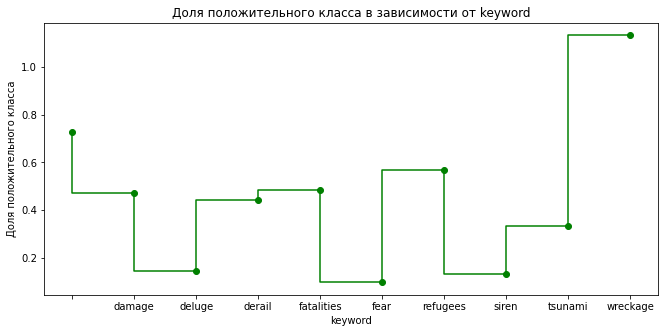

In [21]:
x = keyword_stats['keyword']
y = keyword_stats['share']

fig, ax = plt.subplots(figsize=(11,5))
plt.step(x, y, marker='o', color='green')

ax.set_title('Доля положительного класса в зависимости от keyword')
ax.set_xlabel('keyword')
ax.set_ylabel('Доля положительного класса')

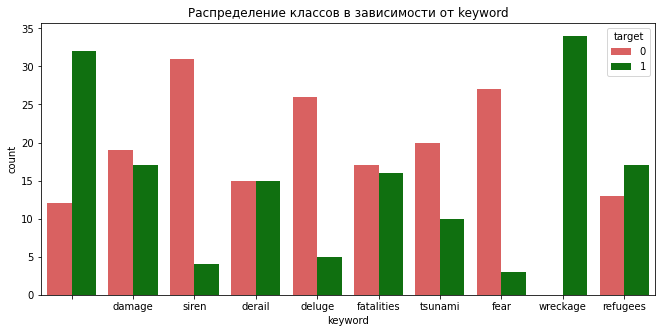

In [22]:
fig, ax = plt.subplots(figsize=(11,5))
countplot(x='keyword', hue='target', data=train[train.keyword.isin(top_keywords['keyword'])], ax=ax, palette=['#ED4D4D', '#008000'])
ax.set_title('Распределение классов в зависимости от keyword')
plt.show()

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [23]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [24]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [25]:
train['text_feature'] = train.keyword.str.cat(train.location, sep=' ').str.cat(train.text, sep=' ')
train.drop(columns=['keyword', 'location', 'text'], inplace=True)

In [26]:
test['text_feature'] = test.keyword.str.cat(test.location, sep=' ').str.cat(test.text, sep=' ')
test.drop(columns=['keyword', 'location', 'text'], inplace=True)

In [27]:
test.head()

,target,text_feature
0,1,destruction So you have a new weapon that can...
1,0,deluge The f$&amp;@ing things I do for #GISHW...
2,1,police UK DT @georgegalloway: RT @Galloway4May...
3,0,aftershock Aftershock back to school kick off...
4,0,"trauma Montgomery County, MD in response to tr..."


In [28]:
train.head()

,target,text_feature
0,0,bridge%20collapse Ashes 2015: AustraliaÛªs c...
1,1,"hail Carol Stream, Illinois GREAT MICHIGAN TEC..."
2,1,police Houston CNN: Tennessee movie theater s...
3,1,rioting Still rioting in a couple of hours le...
4,0,wounds Lake Highlands Crack in the path where ...


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [29]:
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
vec = CountVectorizer()
bow_train = vec.fit_transform(train['text_feature'])

In [31]:
bow_train.shape

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [34]:
from string import punctuation

In [35]:
def cnt_vect_info(vec: CountVectorizer):
    all_words = vec.vocabulary_.keys()
    
    words_w_digits = [word for word in all_words if any(map(str.isdigit, word))]
    words_w_punct = [word for word in all_words if any(i in punctuation for i in word)]
    hashtags_and_mentions = [word for word in all_words if word.startswith('#') or word.startswith('@')]    
    print(f'Содержат цифры: {len(words_w_digits)}')
    print(f'Содержат знаки пунктуации: {len(words_w_punct)}')
    print(f'Хэштеги и упоминания: {len(hashtags_and_mentions)}')


In [36]:
cnt_vect_info(vec)

Содержат цифры: 3812
Содержат знаки пунктуации: 315
Хэштеги и упоминания: 0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [37]:
from nltk.tokenize import TweetTokenizer

In [38]:
vec_w_twt = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
bow_train_twt = vec_w_twt.fit_transform(train['text_feature'])

In [39]:
cnt_vect_info(vec_w_twt)

Содержат цифры: 3939
Содержат знаки пунктуации: 7338
Хэштеги и упоминания: 3149


## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [40]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [41]:
def is_all_latin(token):
    return all(char in 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ' for char in token)

def is_smile(token):
    return all(char in punctuation for char in token) and any(char in '()[]{}' for char in token)

def is_hashtag(token):
    return token[0] == '#' and is_all_latin(token[1:])

def is_stopword(token):
    return token in stopwords.words('english')

def my_filter(token):
    return (is_all_latin(token) or is_smile(token) or is_hashtag(token)) and not is_stopword(token) 

In [42]:
def my_tokenize(text_string):
    
    text_lower = text_string.lower()
    
    text_tokenized = TweetTokenizer().tokenize(text_lower)
    text_tokenized = list(filter(my_filter, text_tokenized))
    
    stemmer = SnowballStemmer('english')
    text_stemmed = [stemmer.stem(token) for token in text_tokenized]
    
    return text_stemmed

In [43]:
for text in train['text_feature'][:10]:
    print(f'{text}')
    print('----------------------------------')
    print(f"{' '.join(my_tokenize(text))}\n\n")

bridge%20collapse  Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
----------------------------------
bridg ash australia collaps trent bridg among worst histori england bundl australia


hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj
----------------------------------
hail carol stream illinoi great michigan techniqu camp thank #goblu #wrestleon


police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR
----------------------------------
polic houston cnn tennesse movi theater shoot suspect kill polic


rioting  Still rioting in a couple of hours left until I have to be up for class.
----------------------------------
riot still riot coupl hour left class


wounds Lake Highlands Crack in the path where I wiped out this morning during beach run. 

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [46]:
my_cnt_vec = CountVectorizer(tokenizer=my_tokenize)
my_cnt_bow_train = my_cnt_vec.fit_transform(train['text_feature'])
my_cnt_bow_test = my_cnt_vec.transform(test['text_feature'])

In [47]:
lr = LogisticRegression()
lr.fit(my_cnt_bow_train, train['target'])

LogisticRegression()

In [48]:
f1_score(test['target'], lr.predict(my_cnt_bow_test))

0.752017213555675

## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
tfidf_vec = TfidfVectorizer(tokenizer=my_tokenize)

my_tfidf_bow_train = tfidf_vec.fit_transform(train['text_feature'])
my_tfidf_bow_test = tfidf_vec.transform(test['text_feature'])

In [51]:
lr_tfidf = LogisticRegression()
lr_tfidf.fit(my_tfidf_bow_train, train['target'])

LogisticRegression()

In [52]:
f1_score(test['target'], lr_tfidf.predict(my_tfidf_bow_test))

0.7412353923205343

C tf-idf векторизатором метрика f1-score стала чуть ниже.

In [53]:
my_tfidf_bow_train.shape

(5329, 10486)

In [54]:
tfidf_vec_2 = TfidfVectorizer(tokenizer=my_tokenize, max_df=0.9)

my_tfidf_bow_train_2 = tfidf_vec_2.fit_transform(train['text_feature'])
my_tfidf_bow_test_2 = tfidf_vec_2.transform(test['text_feature'])

In [55]:
my_tfidf_bow_train_2.shape

(5329, 10486)

In [56]:
lr_tfidf_2 = LogisticRegression()
lr_tfidf_2.fit(my_tfidf_bow_train_2, train['target'])

LogisticRegression()

In [57]:
f1_score(test['target'], lr_tfidf_2.predict(my_tfidf_bow_test_2))

0.7412353923205343

Ни размер матрицы, ни качество не изменилось.

In [58]:
tfidf_vec_3 = TfidfVectorizer(tokenizer=my_tokenize, min_df=0.003)

my_tfidf_bow_train_3 = tfidf_vec_3.fit_transform(train['text_feature'])
my_tfidf_bow_test_3 = tfidf_vec_3.transform(test['text_feature'])

In [59]:
my_tfidf_bow_train_3.shape

(5329, 736)

In [60]:
lr_tfidf_3 = LogisticRegression()
lr_tfidf_3.fit(my_tfidf_bow_train_3, train['target'])

LogisticRegression()

In [61]:
f1_score(test['target'], lr_tfidf_3.predict(my_tfidf_bow_test_3))

0.7266775777414075

Удалось ли добиться улучшения качества? Нет.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [62]:
from sklearn.feature_extraction.text import HashingVectorizer

In [63]:
hash_vec = HashingVectorizer(tokenizer=my_tokenize, n_features=5000)
hash_bow_train = hash_vec.fit_transform(train['text_feature'])
hash_bow_test = hash_vec.transform(test['text_feature'])

In [64]:
hash_lr = LogisticRegression()
hash_lr.fit(hash_bow_train, train['target'])

LogisticRegression()

In [65]:
f1_score(test['target'], hash_lr.predict(hash_bow_test))

0.7190635451505016

Какой из подходов показал самый высокий результат? Просто CountVectorizer.

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [66]:
def my_filter_new(token):
    return (is_all_latin(token) or is_hashtag(token))

In [67]:
def my_tokenize_new(text_string):
    
    text_lower = text_string.lower()
    
    text_tokenized = TweetTokenizer().tokenize(text_lower)
    text_tokenized = list(filter(my_filter_new, text_tokenized))
    
    stemmer = SnowballStemmer('english')
    text_stemmed = [stemmer.stem(token) for token in text_tokenized]
    
    return text_stemmed

In [68]:
my_cnt_vec = CountVectorizer(tokenizer=my_tokenize_new)
my_cnt_bow_train = my_cnt_vec.fit_transform(train['text_feature'])
my_cnt_bow_test = my_cnt_vec.transform(test['text_feature'])

lr = LogisticRegression()
lr.fit(my_cnt_bow_train, train['target'])

f1_score(test['target'], lr.predict(my_cnt_bow_test))

0.7585836909871245

Убрала проверку на скобочки и стоп-слова, чуть лучше стало.

Можно было бы придумать что-то интересное, но я смотрю атаку титанов